# Data Exploration 

In [1]:
#Imports
import pandas as pd
import numpy as np
import datetime
import os
import warnings
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
import tsfresh
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Connect to database 

In [2]:
# Load the file 
json_data = json.loads(open('../../db_conn.json').read())

conn = 'mysql+pymysql://'+json_data["user"]+':'+json_data["password"]+'@'+json_data["host"]+':'+str(json_data["port"])+'/'+json_data["db_name"]

In [3]:
# Connect to the DB
mysql_engine = create_engine(conn,echo=False)

## Explore the sales data

Get the sales data for each of the products at each store, each day in which the sales were above 0. 

In [4]:
sales_df = pd.read_sql_query("""select * from train where units>0""", conn)

In [5]:
sales_df.date = pd.to_datetime(sales_df.date)

In [6]:
store_sales = sales_df.groupby(['date','store_nbr']).sum().reset_index()[['date','store_nbr','units']]
store_sales.head()

,date,store_nbr,units
0,2012-01-01,1,32
1,2012-01-01,2,406
2,2012-01-01,3,326
3,2012-01-01,4,82
4,2012-01-01,5,41


### Sales behavior

In [7]:
sales_df['yearweek'] = sales_df.date.dt.strftime('%Y-%U')

Text(0.5, 1.0, 'Count of items sold during the whole period')

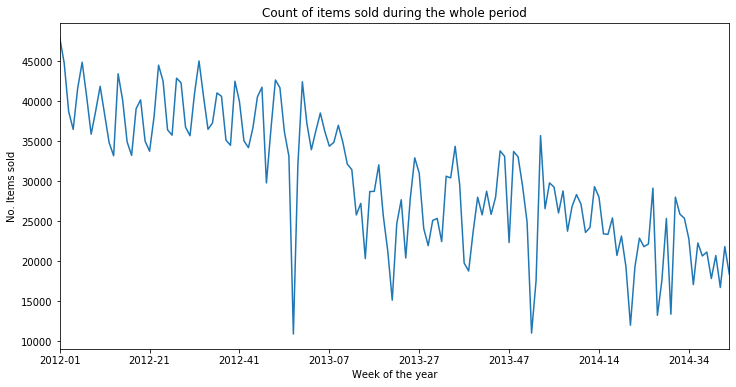

In [8]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
sales_df.groupby('yearweek').sum()['units'].plot(kind='line', ax=ax)
ax.set_xlabel('Week of the year')
ax.set_ylabel('No. Items sold')
ax.set_title('Count of items sold during the whole period')

In general, we see that sales are going down over time, the company is not selling as much of these products as it used to. Furthermore, we see significant seasonality in these 111 products (as expected), hence, forecasting the behavior of these "weather-sensitive" products would be beneficial in terms operations and inventory. 

### Most important products

Now let's check the top items in terms of sales, since these will be the ones presenting difficulties in terms of supply chain and logistics. 

Text(0, 0.5, 'No. Items sold')

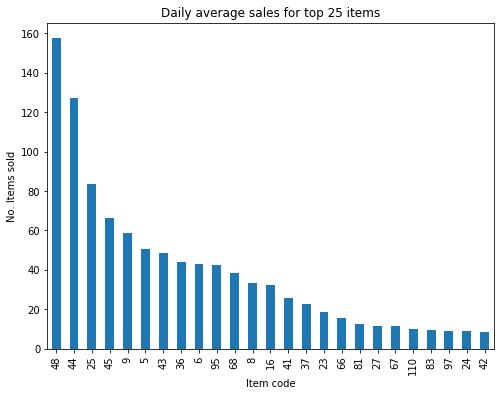

In [9]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
sales_df.groupby('item_nbr')['units'].mean().sort_values(ascending=False).iloc[0:25].plot(kind='bar', ax=ax)
ax.set_title('Daily average sales for top 25 items')
ax.set_xlabel('Item code')
ax.set_ylabel('No. Items sold')

Now let's review the top 25 products when it comes to volume of items sold 

In [10]:
# Get count of items sold over the whole period
product_sales = sales_df.groupby('item_nbr')['units'].sum().sort_values(ascending=False)

[Text(0, 0, '0'),
 Text(0, 0, '200K'),
 Text(0, 0, '400K'),
 Text(0, 0, '600K'),
 Text(0, 0, '800K'),
 Text(0, 0, '1M')]

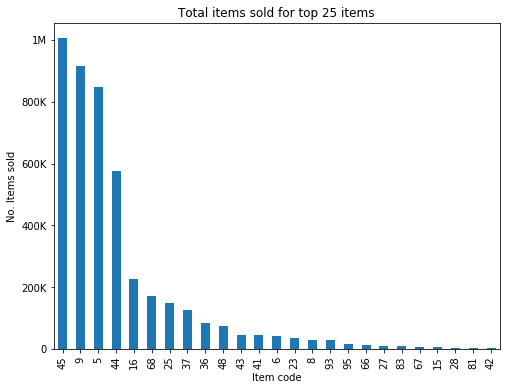

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
product_sales.iloc[0:25].plot(kind='bar', ax=ax)
ax.set_title('Total items sold for top 25 items')
ax.set_xlabel('Item code')
ax.set_ylabel('No. Items sold')
ax.set_yticks([0, 200000, 400000, 600000, 800000, 1000000])
ax.set_yticklabels(['0', '200K', '400K', '600K', '800K', '1M'])

Items 48, 44 and 25 have more average sales, which mean its seasonality character might not be as marked as it is for the top products we see on the graph below, in which we have a signficantly high volume with a signficant daily average of sales. 

This is to say, products 45, 9, 5 and 44 although they have a signficant volume of sales, present more intermitence in their sales periods, which are interesting for analysis for these reasons.

Now let's see the percentage each product represents in total items sold. 

In [12]:
# Get pct of top 3
product_sales.divide(product_sales.sum())[0:3].sum()

0.6075027040834129

In [13]:
# Get count for top 4
product_sales[0:3]

item_nbr
45    1005111
9      916615
5      846662
Name: units, dtype: int64

For this analysis, we have that about 92% of the sales are represented by the top 10 products in sales (out of 111), being products 45, 9 and 5 accountable for about 61% of the total items sold, which is over 2.7 M products sold. It's important here that these two products are 4th and 5th when it comes to daily average sales, which indicates that there might be some **seasonality** for these products. Let's look into it.

In [14]:
#Extract a subset of the sales for these 3 items
subset_sales = sales_df[sales_df.item_nbr.isin([45,9,5])].reset_index(drop=True)

In [15]:
subset_sales.head()

,date,store_nbr,item_nbr,units,yearweek
0,2012-01-01,1,9,29,2012-01
1,2012-01-02,1,9,60,2012-01
2,2012-01-03,1,9,15,2012-01
3,2012-01-04,1,9,20,2012-01
4,2012-01-05,1,9,16,2012-01


Let's review daily behavior first: 

Text(0, 0.5, 'No. Items sold')

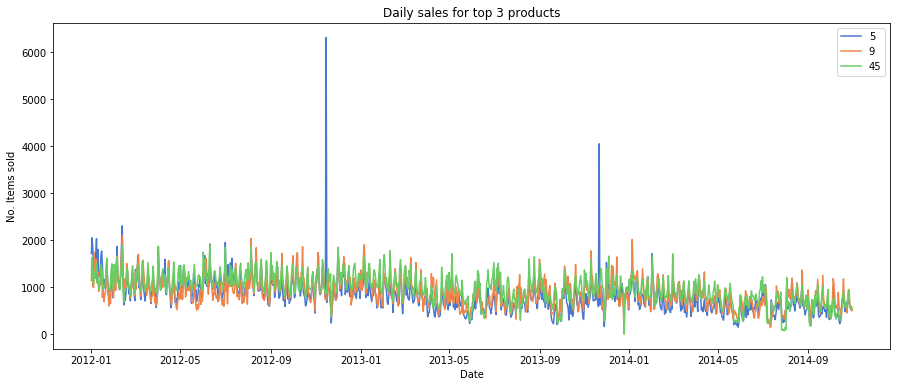

In [16]:
fig, ax = plt.subplots(1,1,figsize=(15,6))
sns.lineplot(data=subset_sales.groupby(['date','item_nbr']).sum().reset_index(), 
             x='date', y='units', hue='item_nbr', palette=sns.color_palette('muted', 3))
ax.legend(['5', '9', '45'])
ax.set_title('Daily sales for top 3 products')
ax.set_xlabel('Date')
ax.set_ylabel('No. Items sold')

We see a decreasing trend for all products, we also see some outliers for product 5, but the volume for these 3 products its quite similar. However, it's difficult to interpret what's going on here, hence, let's try to go for a more aggregated way of looking at the data, for example by week. 

In [17]:
subset_sales['yearweek'] = subset_sales.date.dt.strftime("%Y-%U")

Text(0, 0.5, 'No. Items sold')

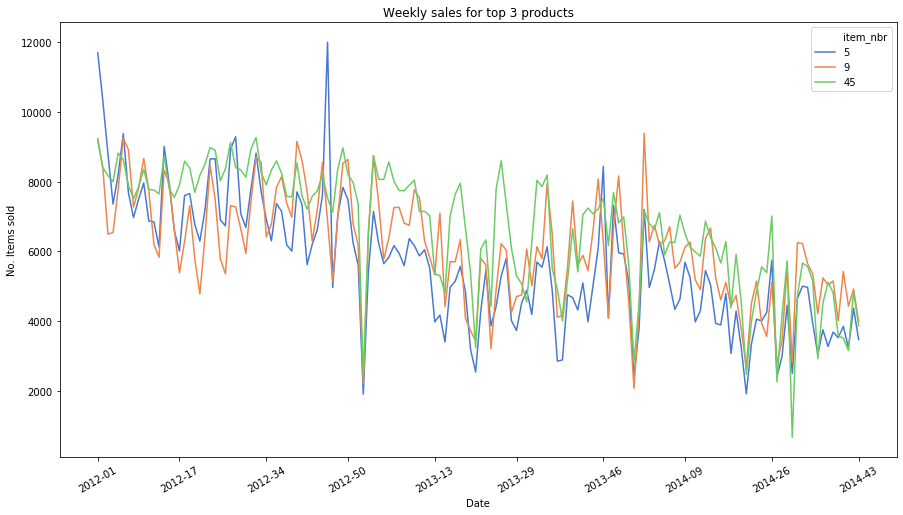

In [18]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
subset_sales_summary = subset_sales.groupby(['yearweek','item_nbr']).sum().reset_index()

#Extract a 10 dates as labels
labels =np.sort(subset_sales.yearweek.unique())[np.linspace(0, subset_sales.yearweek.nunique()-1, 10, dtype=int)]

colors = {45:'red', 9:'blue', 5:'green'}
sns.lineplot(x=subset_sales_summary['yearweek'], 
             y=subset_sales_summary['units'], 
             hue=subset_sales_summary['item_nbr'],
             palette=sns.color_palette("muted", 3),
             ax=ax)
ax.set_xticks(labels)
ax.set_xticklabels(labels, rotation=30)
ax.set_title('Weekly sales for top 3 products')
ax.set_xlabel('Date')
ax.set_ylabel('No. Items sold')

We see a lot of variability in the demand for these products, specifically for number 9, its variability remains constant througout the whole dataset, on the other hand, the variability of product 45 increases significantly over time. These are definetly some products of interest when it comes to sales forecasting and stock provisioning.  

**We will use these 3 products, since they represent a significant percentage of the sales, it will be a major improvement for all stores if we can forecast its demand.** 

## Explore weather data 

In [19]:
#Get number of stores
stores_stations = pd.read_sql_query("""select * FROM RetailWeather.key ORDER BY store_nbr;""", conn)

In [20]:
stores_stations.store_nbr.nunique(), stores_stations.station_nbr.nunique()

(45, 20)

So we have 45 stores, each with one of the 20 weather stations (`station_nbr`) assigned to it, which has recorded the weather conditions for that specific station during 3 years. Now we are going to extract the weather data:

In [21]:
#Get number of stations
weather_df = pd.read_sql_query("""select * from weather;""", conn) 

In [22]:
weather_df.date = pd.to_datetime(weather_df.date)

In [23]:
weather_df.head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,NaT,NaT,RA FZFG BR,NaN,0.05,29.78,29.92,3.6,20.0,4.6
1,1,2012-01-02,50.0,31.0,41.0,NaN,26.0,35.0,24.0,0.0,NaT,NaT,,NaN,0.01,29.44,29.62,9.8,24.0,10.3
2,1,2012-01-03,32.0,11.0,22.0,NaN,4.0,18.0,43.0,0.0,NaT,NaT,,NaN,0.00,29.67,29.87,10.8,31.0,11.6
3,1,2012-01-04,28.0,9.0,19.0,NaN,-1.0,14.0,46.0,0.0,NaT,NaT,,NaN,0.00,29.86,30.03,6.3,27.0,8.3
4,1,2012-01-05,38.0,25.0,32.0,NaN,13.0,25.0,33.0,0.0,NaT,NaT,,NaN,0.00,29.67,29.84,6.9,25.0,7.8


Check if all stations are inside our `stores_stations` data. 

In [24]:
weather_df.station_nbr.unique() in stores_stations.station_nbr.unique()

True

Now that we have the weather conditions for every station, let's take a look at how the weather changes accross the city. 

In [25]:
weather_df.shape

(20517, 20)

Let's analyze this data by month or week across all stations. 

In [26]:
#Add a year-month variable and year-week
weather_df['yearweek'] = weather_df.date.dt.strftime('%Y-%U')
weather_df['yearmonth'] =weather_df.date.dt.strftime('%Y-%m')

Check data continuity for all stations to review similarities/differences between stations 

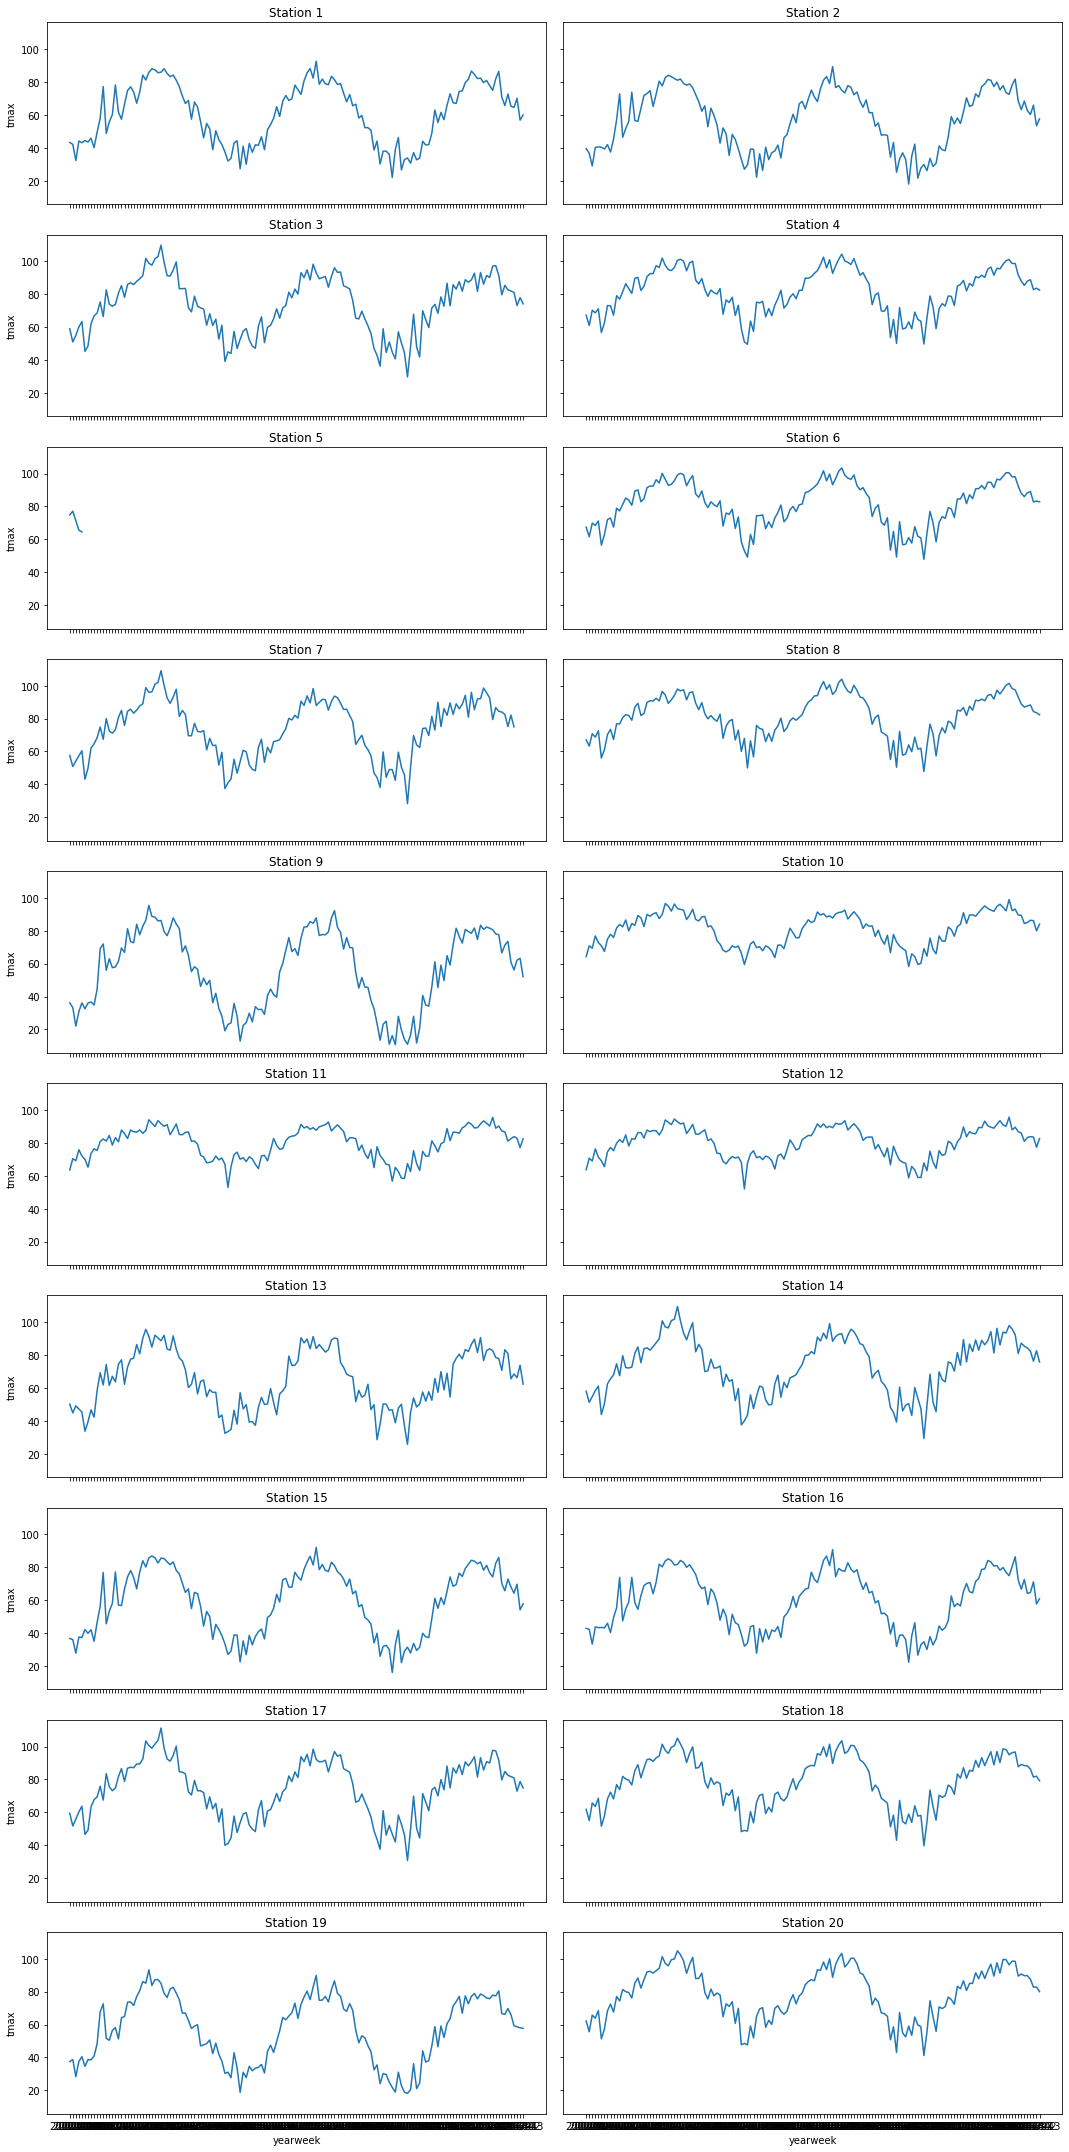

In [27]:
fig, axes = plt.subplots(10,2, figsize=(15,30), sharex=True, sharey=True)

tavg_by_stat = weather_df.groupby(['yearweek', 'station_nbr'])[['tmax']].mean().reset_index()

for ax, station in zip(axes.flat, weather_df.station_nbr.unique()):
    sns.lineplot(data=tavg_by_stat.loc[tavg_by_stat.station_nbr == station], x='yearweek', y='tmax', ax=ax)
    ax.set_title(f'Station {station}')

fig.tight_layout()

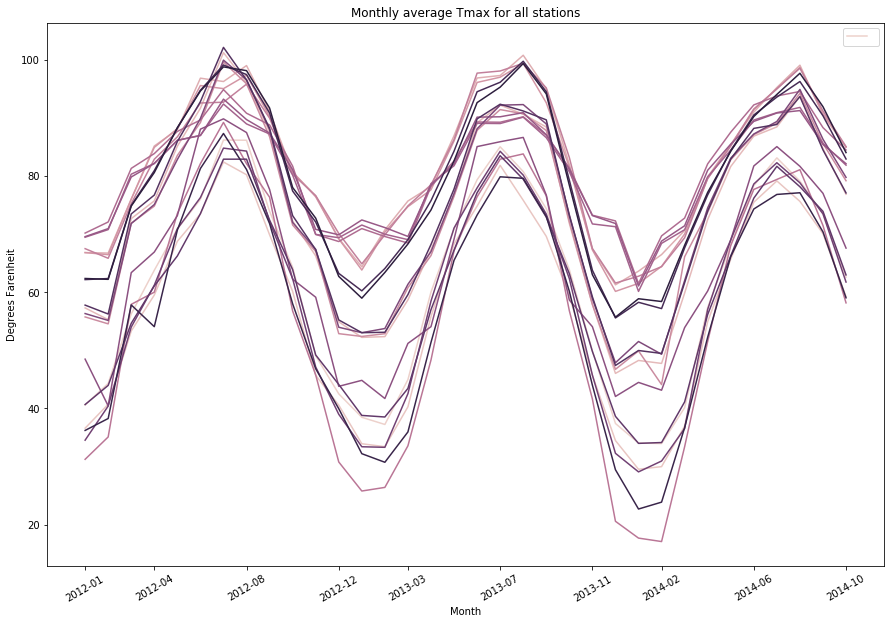

In [28]:
tavg_by_stat = weather_df.groupby(['yearmonth', 'station_nbr'])[['tmax']].mean().reset_index()

#Extract a 10 dates as labels
labels =np.sort(weather_df.yearmonth.unique())[np.linspace(0, weather_df.yearmonth.nunique()-1, 10, dtype=int)]

fig,ax = plt.subplots(1,1, figsize=(15,10))
sns.lineplot(data=tavg_by_stat, x='yearmonth', y='tmax', hue='station_nbr', ax=ax)
ax.set_xticks(labels)
ax.set_xticklabels(labels, rotation=30)
ax.set_title('Monthly average Tmax for all stations')
ax.set_xlabel('Month')
ax.set_ylabel('Degrees Farenheit')
ax.legend([None])

Some observations from this section:

* We have significant null values in every station, we will have to work on those later.
* Stations 5 and 8 (and all stores related to these) will be ommited from the analysis since they are incomplete and mostly null.
* We can see that the temperature across stations is not similar at all, not even aggregated by month, hence, we will will not be able to use the complete dataset in order to generate a generalized model.
* In the last plot, we see the monthly behavior of the maximum temperature across all stations, it's evidenced here that temperatures tend to group in 3 to 4 clusters with similar behavior, indicating that the readings from these stations are similar and could be in the same area (or city). 

## Grouping different stations (stores) by weathers 

Since we know that all stores have one station associated to it, and we also know that some stations are similar in terms of its weather characteristics, we might generalize models for these three clusters of stations and stores in order to obtain a model suited for each kind of weather. 

### `tsfresh` time-series feature extraction  

In order to compare the different time series, we are going to use `tsfresh` This package allows us to extract relevant features of each of the time series from over 1200 features extracted, which the can be used for clustering time series with similar characteristics. 

Let's filter out stations 5 and 8 given data incompleteness previously evidenced. 

In [29]:
weather_df = weather_df[~weather_df.station_nbr.isin([5,8])]

#### Data preprocessing 

First, let's take a look at the NAs for the entire dataset 

In [30]:
weather_df.isna().sum().sort_values(ascending=False)

depart         9654
sunrise        8590
sunset         8590
snowfall       5372
wetbulb         336
sealevel        242
heat            179
cool            179
tavg            179
dewpoint        170
resultspeed     111
resultdir       111
tmin             74
tmax             70
stnpressure      67
avgspeed         48
preciptotal      33
date              0
yearmonth         0
yearweek          0
codesum           0
station_nbr       0
dtype: int64

We see a significant amount of null values that we will have to deal with in the future, but first let's check correlation between variables. 

#### Studying correlation between weather variables 

Weather related variables are known to present significant correlation for different categories (Watanabe et al.), i.e. temperatures, precipitations, pressures, etc. Therefore, it's important to evaluate such correlations in order to clean our weather features and remove collinearity. Let's take a look at how variables are correlated to each other:

[Text(0, 0, 'tmax'),
 Text(0, 0, 'tmin'),
 Text(0, 0, 'tavg'),
 Text(0, 0, 'depart'),
 Text(0, 0, 'dewpoint'),
 Text(0, 0, 'wetbulb'),
 Text(0, 0, 'heat'),
 Text(0, 0, 'cool'),
 Text(0, 0, 'snowfall'),
 Text(0, 0, 'preciptotal'),
 Text(0, 0, 'stnpressure'),
 Text(0, 0, 'sealevel'),
 Text(0, 0, 'resultspeed'),
 Text(0, 0, 'resultdir'),
 Text(0, 0, 'avgspeed')]

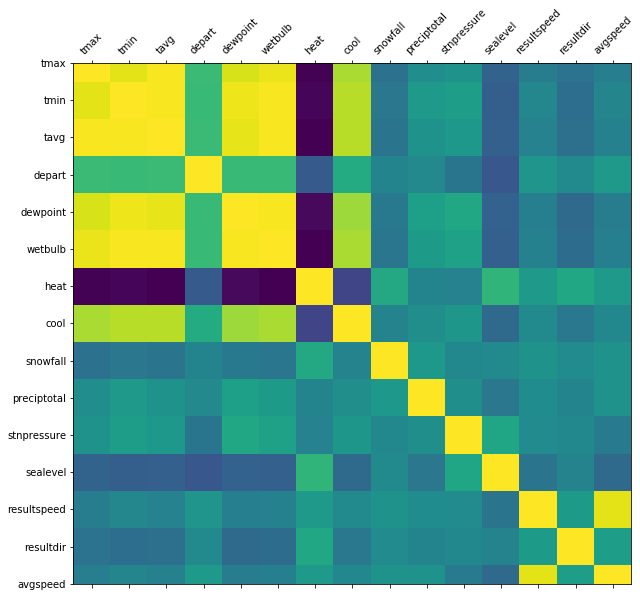

In [31]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

names = weather_df.columns[~weather_df.columns.isin(['date', 
                                                     'station_nbr',
                                                     'yearmonth',
                                                     'yearweek',
                                                    'codesum',
                                                    'sunrise',
                                                    'sunset'])]

ax.matshow(weather_df[names].corr(),
               interpolation='none')
#fig.colorbar(im)

ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=45)
ax.set_yticks(np.arange(len(names)))
ax.set_yticklabels(names)


Now, we can apply a PCA over this correlation matrix in order to check how these different features are related. 

In [32]:
# Subset our to numerical variables only
X = weather_df[names]
X = X.dropna(how='any')
X.shape

#Get correlation matrix
similarities = X.corr()

In [33]:
# Instantiate PCA
pca = PCA(n_components=2)
corr_pca = pca.fit_transform(similarities)

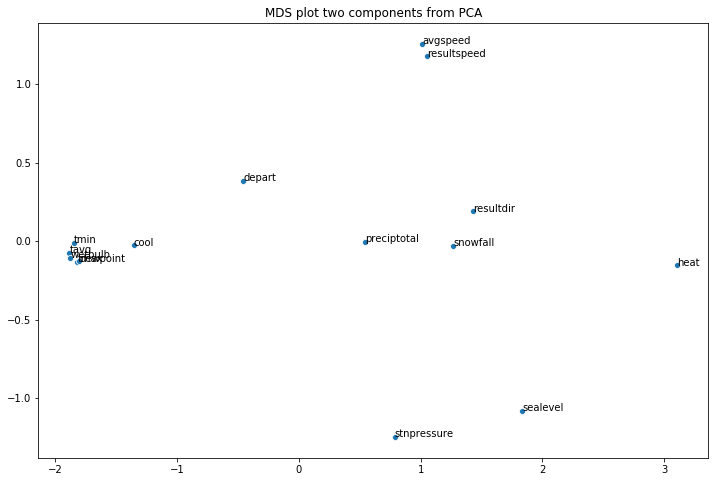

In [34]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

sns.scatterplot(x=corr_pca[:,0], 
                y=corr_pca[:,1], ax=ax)
ax.set_title('MDS plot two components from PCA')

for i, txt in enumerate(X.columns):
    ax.annotate(txt, (corr_pca[i,0],
                      corr_pca[i,1]))

Considering this observation and other related factors like data sparseness, we will select the following variables as the explanatory weather variables of the analysis:

* average atmospheric pressure at station (`stnpressure`)
* total precipitation (`preciptotal`)
* maximum temperature (`tmax`)
* average wind speed (`avgspeed`)

In [35]:
weather_feat = weather_df[['station_nbr', 'yearmonth', 'stnpressure', 'preciptotal', 'tmax', 'preciptotal']]
#Drop resulting NAs
weather_feat = weather_feat.dropna(how='any')

In [36]:
weather_feat.station_nbr.nunique()

18

After we remove NAs, we end up with 18 stations that are active and have data to be clusterd.

#### Applying `tsfresh` feature extraction 

Now we will aim to extract multiple features out of these time series, in order to evaluate similarities between them. Some examples of features this package obtains are: no. of peak points, no. of valley points, averages, etc. 

In [37]:
extracted_features = tsfresh.extract_features(weather_feat, column_id="station_nbr", column_sort="yearmonth")

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 18/18 [02:16<00:00,  7.59s/it]


As shown in the package documentation, this feature extraction process generates a significant number of NAs in the process. We will have to remove the features containing NAs for the clustering process. 

In [38]:
#Remove NAs
extracted_features = extracted_features.dropna(axis=1, how='any')

In [39]:
extracted_features.shape

(18, 2247)

So we extracted more than 2200 features for every station's time series that we can use to cluster. However, that might be too much, we will apply PCA to reduce dimensionality the number of features.

In [40]:
pca = PCA(n_components=18) #Max number of PCA dims
extracted_features_pca = pca.fit_transform(extracted_features)

In [41]:
extracted_features_pca.shape

(18, 18)

We have 18 features for our 18 stations that we can use to apply a clustering algorithm and obtain the clusters of stations. 

### Cluster the weather stations

We will now use those features for each time series to cluster weather stations usnig KMeans

In [42]:
#Get feature matrix
X = extracted_features_pca

# Create vector for number of clusters 
no_clusters = np.linspace(2,10,9, dtype='int')

# Create instances of model and fit all models
km_models = [KMeans(n_clusters=no).fit(X) for no in no_clusters]

# Get scree plot to detect elbow
inertias = [model.inertia_ for model in km_models]

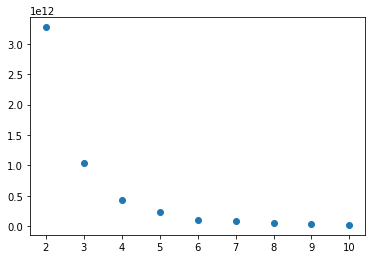

In [43]:
plt.scatter(x=no_clusters, y=inertias)

It seems like the optimal amount of clusters is between 3 and 4, let's extract the labels and confirm visually if the time series are clustered correctly when we pick 3 clusters of ts.

In [44]:
# Get model with 3 clusters
optimal_km = km_models[1]

In [45]:
# Get cluster labels
labels = optimal_km.labels_

In [46]:
#Get cluster counts
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 7, 1: 7, 2: 4}

It's balanced enough, now we will create a map of labels for each of the `station_nbr` 

In [47]:
labels_map = {station: label for station, label in zip(extracted_features.index.unique(), labels)}

In [48]:
labels_map

{1: 1,
 2: 1,
 3: 2,
 4: 0,
 6: 0,
 7: 2,
 9: 1,
 10: 0,
 11: 0,
 12: 0,
 13: 1,
 14: 2,
 15: 1,
 16: 1,
 17: 2,
 18: 0,
 19: 1,
 20: 0}

Back to our plot from a previous section, we will plot the maximum temperature and the stations from the same cluster using the same color.

In [49]:
tmax_by_stat = weather_df.groupby(['yearmonth', 'station_nbr'])[['tmax']].mean().reset_index()

In [50]:
# Add the cluster to which it belongs using the map
tmax_by_stat['cluster'] = tmax_by_stat.station_nbr.apply(lambda x: labels_map[x])

Text(0, 0.5, 'Degrees Farenheit')

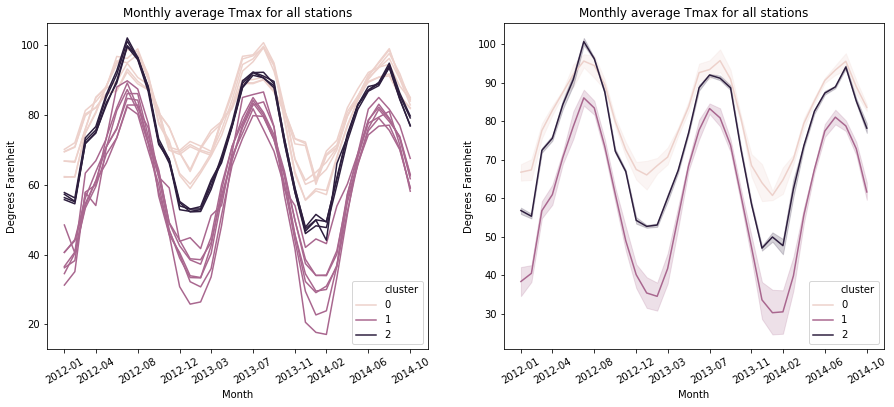

In [51]:
fig,ax = plt.subplots(1,2, figsize=(15,6))

#Extract a 10 dates as labels
labels =np.sort(weather_df.yearmonth.unique())[np.linspace(0, weather_df.yearmonth.nunique()-1, 10, dtype=int)]

# All series
sns.lineplot(data= tmax_by_stat, 
             x='yearmonth', 
             y='tmax',
             hue='cluster',
             units='station_nbr', 
             estimator=None,
             ax=ax[0])
ax[0].set_xticks(labels)
ax[0].set_xticklabels(labels, rotation=30)
ax[0].set_title('Monthly average Tmax for all stations')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Degrees Farenheit')

# Means
sns.lineplot(data= tmax_by_stat, x='yearmonth', y='tmax', hue='cluster', ax=ax[1])

ax[1].set_xticks(labels)
ax[1].set_xticklabels(labels, rotation=30)
ax[1].set_title('Monthly average Tmax for all stations')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Degrees Farenheit')

We then see three clusters of stations, which we will call "cities". We will use these cities, to cluster the activity at each of the stores so that we can **generalize the prediction model by cities** and it can be used by multiple stores and the data can be shared across stores of the same city.  

This `label_map` variable would be very useful to tag activities from all stores, we will save it to a file to load it later.

In [52]:
pd.DataFrame({'stores': list(labels_map.keys()),
             'cluster': list(labels_map.values())}).set_index('stores').to_csv('labels_map.csv')

### Future work: some other variables that could be used for the analysis 

* weather related variables
* quantity sold the previous day
* day of the week
* season
* price (check)
